In [1]:
import pandas as pd
import torch
import sys
import matplotlib.pyplot as plt


sys.path.append("../../")
from src.vae_architectures.lstm import LSTMVariationalAutoEncoder
from src.vae_architectures.signal_cnn import SignalCNNVariationalAutoEncoder
from src.vae_architectures.graph_cnn import GraphVariationalAutoEncoder
from src.dataset import ExerciseDataset

In [2]:
from src.utils.constants import (HIDDEN_SIZE, LATENT_SIZE, NUM_JOINTS,
                                 NUM_LAYERS, SEQUENCE_LENGTH)


In [3]:
dct_lstm_autoencoder = LSTMVariationalAutoEncoder(
                SEQUENCE_LENGTH, NUM_JOINTS * 3, HIDDEN_SIZE, LATENT_SIZE, NUM_LAYERS
            )
dct_lstm_autoencoder.load_state_dict(
    torch.load("../../models/squat/dct_lstm.pt", map_location=torch.device("cpu"))
)

dct_cnn_autoencoder = SignalCNNVariationalAutoEncoder(
                SEQUENCE_LENGTH, NUM_JOINTS * 3, HIDDEN_SIZE, LATENT_SIZE
            )
dct_cnn_autoencoder.load_state_dict(
    torch.load("../../models/squat/dct_cnn.pt", map_location=torch.device("cpu"))
)

dct_graph_autoencoder = GraphVariationalAutoEncoder(
                SEQUENCE_LENGTH, NUM_JOINTS * 3, HIDDEN_SIZE, LATENT_SIZE
            )
dct_graph_autoencoder.load_state_dict(
    torch.load("../../models/squat/dct_graph.pt", map_location=torch.device("cpu"))
)

<All keys matched successfully>

In [5]:
squat_dct_train_df = pd.read_csv("../../data/train/squat/dct.csv")
squat_dct_dataset = ExerciseDataset(squat_dct_df, representation="dct")

squat_dct_test_df = pd.read_csv("../../data/test/squat/dct.csv")
squat_dct_dataset_test = ExerciseDataset(squat_dct_test_df, representation="dct")

In [6]:
import numpy as np

X_train_squat = torch.stack([rep for rep in squat_dct_dataset.data])
y_train_squat = np.array([1 if label == 0 else 0 for label in squat_dct_dataset.labels_encoded])

X_test = torch.stack([rep for rep in squat_dct_dataset_test.data])
y_test = np.array(
    [1 if label == 0 else 0 for label in squat_dct_dataset_test.labels_encoded]
)


In [7]:
models = {
    "lstm": dct_lstm_autoencoder,
    "cnn": dct_cnn_autoencoder,
    "graph": dct_graph_autoencoder,
}

/Users/hubert/Github-Repositories/explainable-methods-in-exercise-analysis/.env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hubert/Github-Repositories/explainable-methods-in-exercise-analysis/.env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/hubert/Github-Repositories/explainable-methods-in-exercise-analysis/.env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hubert/Github-Repositories/explainable-methods-in-exercise-analysis/.env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/U

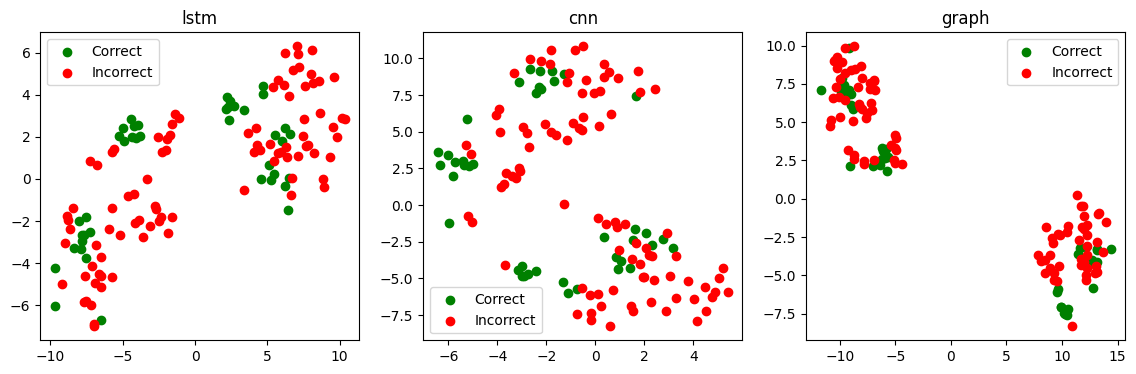

In [8]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
fig, axes = plt.subplots(ncols=3, figsize=(14, 4))

for (model_name, model), axis in zip(models.items(), axes):
    X_embedded = model.encoder(X)[0].detach().numpy()
    X_test_embedded = model.encoder(X_test)[0].detach().numpy()

    latent_space = tsne.fit_transform(np.concatenate([X_embedded, X_test_embedded]))
    all_y = np.concatenate([y, y_test])
    axis.scatter(latent_space[all_y == 1][:, 0], latent_space[all_y == 1][:, 1], c="green")
    axis.scatter(latent_space[all_y == 0][:, 0], latent_space[all_y == 0][:, 1], c="red")

    axis.legend(["Correct", "Incorrect"])
    axis.set_title(model_name)

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score


for model_name, model in models.items():
    f1 = []
    for _ in range(50):
        X_embedded = model.encoder(X)[0].detach().numpy()
        X_test_embedded = model.encoder(X_test)[0].detach().numpy()

        clf = DecisionTreeClassifier().fit(X_embedded, y)
        y_pred = clf.predict(X_test_embedded)
        f1.append(f1_score(y_test, y_pred))
    print(f"{model_name} mean f1-score: {np.mean(f1)}, std: {np.std(f1)}")


lstm mean f1-score: 0.6648115149533913, std: 0.054735913454448185
cnn mean f1-score: 0.3565421245421245, std: 0.06705413144939218
graph mean f1-score: 0.7253754940711462, std: 0.007509465351486439
